In [1]:
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm_notebook as tqdm
import pickle
import os
from typing import List, Dict

In [2]:
os.chdir("/Users/edwardgan/Documents/Projects/sketchstore/python")

In [3]:
import sketch.compress_freq
import sketch.sketch_frequent
import sketch.compress_dyadic
import sketch.sketch_gen
import storyboard.board_gen

In [4]:
colormap = {
    "cooperative": "C0",
    "truncation": "C1",
    "pps": "C2",
    "random_sample": "C3",
    "dyadic_b2": "C6",

    "q_cooperative": "C0",
    "q_truncation": "C1",
    "q_pps": "C2",
    "q_random_sample": "C3",
    "q_dyadic_b2": "C6",
    
    "spacesaving": "C4",
    "cms_min": "C5",
    "kll": "C4",
}
markers = {
    "cooperative": "x",
    "truncation": "^",
    "pps": "s",
    "random_sample": "+",
    "dyadic_b2": "<",

    "q_cooperative": "x",
    "q_truncation": "^",
    "q_pps": "s",
    "q_random_sample": "+",
    "q_dyadic_b2": "<",

    "spacesaving": "D",
    "cms_min": "o",
    "kll": "D",
}
alg_display_name = {
    "cooperative": "Cooperative",
    "truncation": "Truncation",
    "pps": "VarOPT",
    "random_sample": "Unif. Sampling",
    "dyadic_b2": "P-adic (base 2)",

    "q_cooperative": "Cooperative",
    "q_truncation": "Truncation",
    "q_pps": "PPS",
    "q_random_sample": "Unif. Samp.",
    "q_dyadic_b2": "P-adic (base 2)",

    "spacesaving": "Space Saving Sketch",
    "cms_min": "CountMinSketch",
    "kll": "KLL",
}

In [5]:
def get_error_file(dataset_name, granularity, sketch_name, sketch_size):
    return os.path.join(
        "output/boards/{}_{}/".format(dataset_name,granularity),
        "{}_{}_errors.csv".format(sketch_name, sketch_size)
    )

# Multi Dataset

In [7]:
def query_length_plot(
    dataset_name,
    granularity,
    sketch_names: List,
    sketch_sizes: Dict,
    err_measure="max",
    ax = None
):
    e_fnames = [
        get_error_file(
        dataset_name, granularity, cur_name, sketch_sizes[cur_name]
        )
        for cur_name in sketch_names
    ]
    e_dfs = [pd.read_csv(f) for f in e_fnames]
    e_combined = pd.concat(e_dfs, axis=0)
    eg = e_combined.groupby(["sketch", "query_len"]).aggregate({
        err_measure: ["mean", "std"],
        "total": ["mean"]
    })
    eg["err_norm"] = eg[(err_measure, "mean")] / eg[("total", "mean")]
    eg["err_norm_std"] = eg[err_measure, "std"] / eg[("total", "mean")]
    if ax is None:
        f = plt.figure(figsize=(6,4.5))
        ax = f.gca()
    for method in sketch_names:
        eg_cur = eg.loc[method]
        ax.errorbar(
            eg_cur.index,
            eg_cur["err_norm"],
            yerr=eg_cur["err_norm_std"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
    #         markevery=2,
        )
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(dataset_name)
    return ax

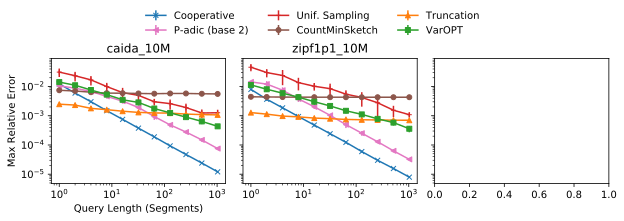

In [43]:
sketch_names = ["cooperative", "dyadic_b2", "random_sample", "cms_min", "truncation", "pps"]
sketch_sizes = {
    "cooperative": 64,
    "random_sample": 64,
    "cms_min": 64,
    "truncation": 64,
    "pps": 64,
    "dyadic_b2": 5,
    "dyadic_b3": 9
}
h_datasets = [
    ("caida_10M", 2048), 
    ("zipf1p1_10M", 2048),
]

fig, axs = plt.subplots(figsize=(10,2.3), nrows=1, ncols=3, sharey=True, dpi=100)
plt.subplots_adjust(wspace=.1)

di = 0
for dataset_name, granularity in h_datasets:
    query_length_plot(
        dataset_name,
        granularity,
        sketch_names,
        sketch_sizes,
        err_measure="max",
        ax=axs[di]
    )
    di += 1

axs[0].set_xlabel("Query Length (Segments)")
axs[0].set_ylabel("Max Relative Error")

lgd = axs[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(1.5, 1.45), ncol=3)
# fig.tight_layout()
fname = "output/plots/linear_freq.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [17]:
f = get_error_file(
    dataset_name="power_2M", granularity=2048, sketch_name="q_cooperative", sketch_size=64
)

In [18]:
df = pd.read_csv(f)

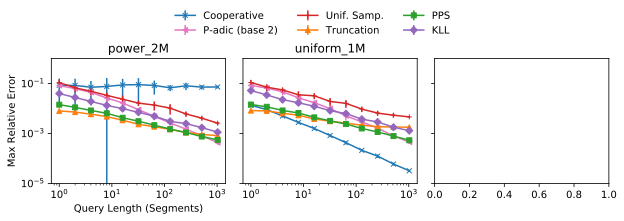

In [21]:
sketch_names = ["q_cooperative", "q_dyadic_b2", "q_random_sample", "q_truncation", "q_pps", "kll"]
sketch_sizes = {
    "q_cooperative": 64,
    "q_random_sample": 64,
    "q_truncation": 64,
    "q_pps": 64,
    "kll": 64,
    "q_dyadic_b2": 5,
    "q_dyadic_b3": 9,
}

h_datasets = [
    ("power_2M", 2048),
    ("uniform_1M", 2048), 
]

fig, axs = plt.subplots(figsize=(10,2.3), nrows=1, ncols=3, sharey=True, dpi=100)
plt.subplots_adjust(wspace=.1)

di = 0
for dataset_name, granularity in h_datasets:
    query_length_plot(
        dataset_name,
        granularity,
        sketch_names,
        sketch_sizes,
        err_measure="max",
        ax=axs[di]
    )
    di += 1

axs[0].set_xlabel("Query Length (Segments)")
axs[0].set_ylabel("Max Relative Error")
axs[0].set_ylim(10**-5, 1)

lgd = axs[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(1.5, 1.45), ncol=3)
# fig.tight_layout()
fname = "output/plots/linear_quant.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

# Single Dataset

In [100]:
def query_length_plot(
    dataset_name,
    granularity,
    sketch_names: List,
    sketch_sizes: Dict,
    err_measure="max"
):
    e_fnames = [
        get_error_file(
        dataset_name, granularity, cur_name, sketch_sizes[cur_name]
        )
        for cur_name in sketch_names
    ]
    e_dfs = [pd.read_csv(f) for f in e_fnames]
    e_combined = pd.concat(e_dfs, axis=0)
    eg = e_combined.groupby(["sketch", "query_len"]).aggregate({
        err_measure: ["mean", "std"],
        "total": ["mean"]
    })
    eg["err_norm"] = eg[(err_measure, "mean")] / eg[("total", "mean")]
    eg["err_norm_std"] = eg[err_measure, "std"] / eg[("total", "mean")]
    f = plt.figure(figsize=(6,4.5))
    ax = f.gca()
    for method in sketch_names:
        eg_cur = eg.loc[method]
        ax.errorbar(
            eg_cur.index,
            eg_cur["err_norm"],
            yerr=eg_cur["err_norm_std"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
    #         markevery=2,
        )
    ax.set_xscale("log")
    ax.set_yscale("log")
    lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3)
    ax.set_xlabel("Query Length (Segments)")
    ax.set_ylabel("{} Relative Error".format(err_measure))
    ax.set_title("{}".format(dataset_name))
    f.tight_layout()
    fname = "output/plots/linear_{}.pdf".format(dataset_name)
    f.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return f, ax

(<Figure size 432x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1229cd940>)

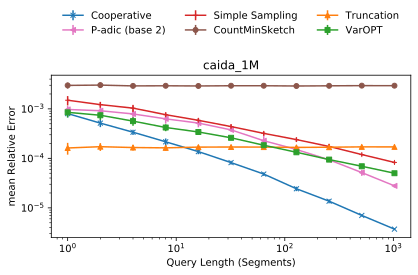

In [101]:
sketch_names = ["cooperative", "dyadic_b2", "random_sample", "cms_min", "truncation", "pps"]
sketch_sizes = {
    "cooperative": 64,
    "random_sample": 64,
    "cms_min": 64,
    "truncation": 64,
    "pps": 64,
    "dyadic_b2": 5,
    "dyadic_b3": 9
}
dataset_name = "caida_1M"
granularity = 2048
query_length_plot(
    dataset_name,
    granularity,
    sketch_names,
    sketch_sizes,
    err_measure="mean",
)

(<Figure size 432x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122d1f710>)

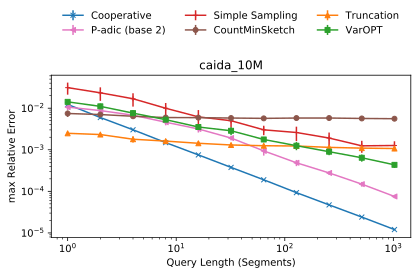

In [104]:
sketch_names = ["cooperative", "dyadic_b2", "random_sample", "cms_min", "truncation", "pps"]
sketch_sizes = {
    "cooperative": 64,
    "random_sample": 64,
    "cms_min": 64,
    "truncation": 64,
    "pps": 64,
    "dyadic_b2": 5,
    "dyadic_b3": 9
}
dataset_name = "caida_10M"
granularity = 2048
query_length_plot(
    dataset_name,
    granularity,
    sketch_names,
    sketch_sizes,
    err_measure="max"
)

(<Figure size 432x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1234c3390>)

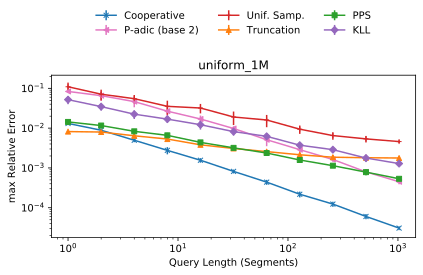

In [106]:
sketch_names = ["q_cooperative", "q_dyadic_b2", "q_random_sample", "q_truncation", "q_pps", "kll"]
sketch_sizes = {
    "q_cooperative": 64,
    "q_random_sample": 64,
    "q_truncation": 64,
    "q_pps": 64,
    "kll": 64,
    "q_dyadic_b2": 5,
    "q_dyadic_b3": 9,
}
dataset_name = "uniform_1M"
granularity = 2048
query_length_plot(
    dataset_name,
    granularity,
    sketch_names,
    sketch_sizes,
    err_measure="max"
)